In [1]:
import torch
import torchvision
import sklearn
import numpy as np
import pandas as pd
import time
import scipy
import sys
import glob
import cv2 
import os
import PIL
import multiprocessing as mp
import contextlib
import io
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

#pytorch and torchvision imports
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import Sampler
from torchvision import transforms
from torchvision.models import resnet50

#for displaying images from dataset
from IPython.display import Image

In [2]:
!ls

archive.zip                            png_train_images
breast-cancer-detection original.ipynb test.csv
breast-cancer-detection.ipynb          train.csv


In [3]:
import os

folder_path = 'png_train_images/'  
files = os.listdir(folder_path)

In [4]:
from pathlib import Path

df = pd.read_csv("train.csv")

image_path  = Path('png_train_images/')

path = []
for i in tqdm(range(len(df))):
    row = df.iloc[i, :]
    filename = str(row.patient_id) + "/" + str(row.image_id) + ".png"
    path.append(image_path /  filename )
df["path"] = path

  0%|          | 0/54706 [00:00<?, ?it/s]

In [5]:
df

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,png_train_images/10006/462822612.png
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,png_train_images/10006/1459541791.png
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,png_train_images/10006/1864590858.png
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,png_train_images/10006/1874946579.png
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,png_train_images/10011/220375232.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54701,1,9973,1729524723,R,MLO,43.0,0,0,0,1.0,0,C,49,False,png_train_images/9973/1729524723.png
54702,1,9989,63473691,L,MLO,60.0,0,0,0,NaN,0,C,216,False,png_train_images/9989/63473691.png
54703,1,9989,1078943060,L,CC,60.0,0,0,0,NaN,0,C,216,False,png_train_images/9989/1078943060.png
54704,1,9989,398038886,R,MLO,60.0,0,0,0,0.0,0,C,216,True,png_train_images/9989/398038886.png


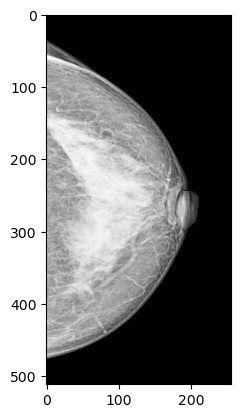

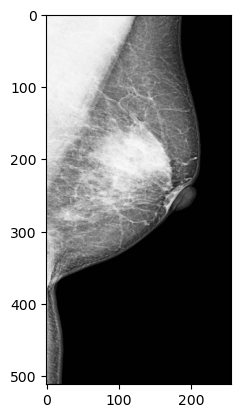

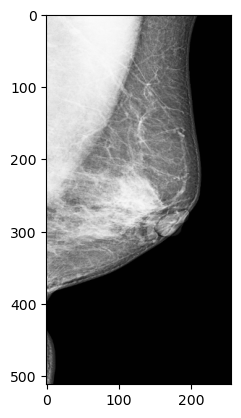

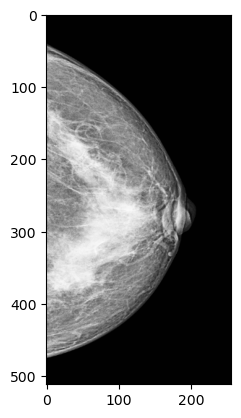

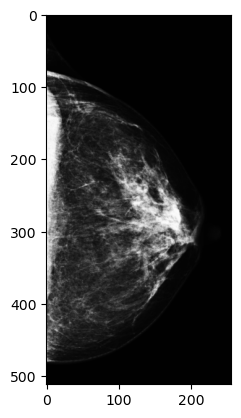

In [6]:
for i in range(5):
    img_read = cv2.imread(str(df["path"][i]), cv2.IMREAD_UNCHANGED)
    plt.imshow(img_read)
    plt.show()

In [7]:
total_images = len(df)
print(total_images)
patient_num = len(df["patient_id"].unique())
print(patient_num)

54706
11913


In [8]:
df["cancer"].unique()

array([0, 1])

In [9]:
dd = df[df["cancer"]==1]

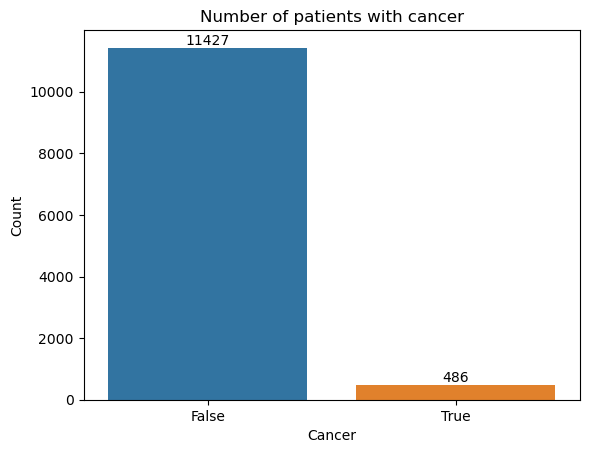

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

def has_cancer(c):
    return c > 0

cancer_per_patient = df.groupby("patient_id")["cancer"].sum().apply(has_cancer)

ax = sns.countplot(x=cancer_per_patient)
ax.bar_label(ax.containers[0])

plt.xlabel("Cancer")
plt.ylabel("Count")
plt.title("Number of patients with cancer")

plt.show()


Text(0.5, 1.0, 'Patient ages')

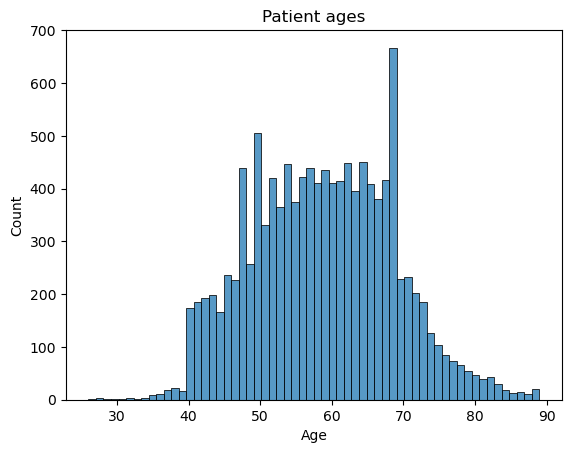

In [11]:
def get_age(a):
    return a[0]
    
patient_age = df[df['age'].isnull()==False].groupby("patient_id").age.unique().apply(lambda a: get_age(a))
sns.histplot(patient_age.values, bins=60)
plt.xlabel("Age")
plt.title("Patient ages")

In [12]:
cancer = df[df["cancer"]==1]
nocancer = df[df["cancer"]==0].sample(n=len(cancer))
print(len(cancer), len(nocancer))

1158 1158


In [13]:
df_balanced = pd.concat([cancer, nocancer], axis=0)
df_balanced

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
87,1,10130,388811999,L,MLO,71.0,1,1,1,0.0,0,B,49,False,png_train_images/10130/388811999.png
88,1,10130,613462606,L,CC,71.0,1,1,1,0.0,0,B,49,False,png_train_images/10130/613462606.png
89,1,10130,1360338805,L,CC,71.0,1,1,1,0.0,0,B,49,False,png_train_images/10130/1360338805.png
90,1,10130,1672636630,L,MLO,71.0,1,1,1,0.0,0,B,49,False,png_train_images/10130/1672636630.png
190,1,10226,461614796,L,MLO,71.0,1,1,1,0.0,0,C,49,False,png_train_images/10226/461614796.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25707,2,37467,474761252,R,CC,62.0,0,0,0,NaN,0,NaN,48,False,png_train_images/37467/474761252.png
47193,2,60745,1783018371,L,MLO,56.0,0,0,0,NaN,0,NaN,29,False,png_train_images/60745/1783018371.png
15000,1,2600,1946902540,R,CC,64.0,0,0,0,1.0,0,A,49,False,png_train_images/2600/1946902540.png
5347,2,15810,448093818,L,MLO,66.0,0,0,0,NaN,0,NaN,21,False,png_train_images/15810/448093818.png


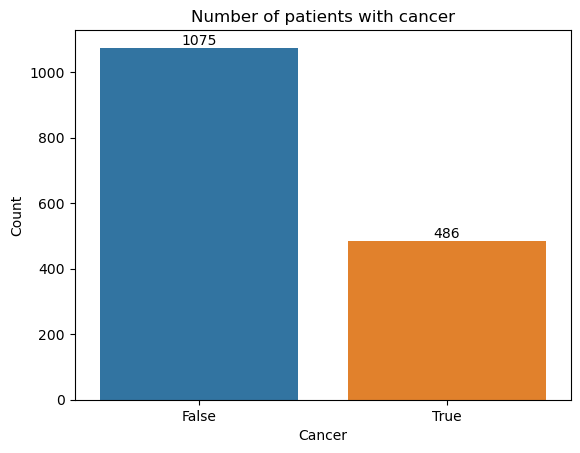

In [14]:
cancer_per_patient = df_balanced.groupby("patient_id")["cancer"].sum().apply(has_cancer)

ax = sns.countplot(x=cancer_per_patient)
ax.bar_label(ax.containers[0])

plt.xlabel("Cancer")
plt.ylabel("Count")
plt.title("Number of patients with cancer")

plt.show()

### Patients age with cancer (positive diagnosis)

Text(0.5, 1.0, 'Patient ages')

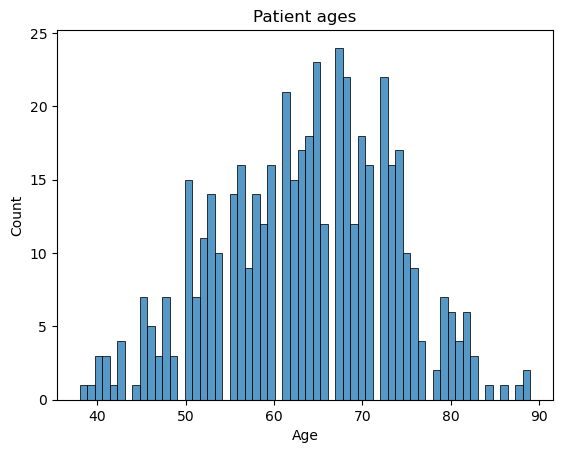

In [15]:
patient_age = cancer[cancer['age'].isnull()==False].groupby("patient_id").age.unique().apply(lambda a: get_age(a))
sns.histplot(patient_age.values, bins=60)
plt.xlabel("Age")
plt.title("Patient ages")

### Patients age without cancer (negative diagnosis)

Text(0.5, 1.0, 'Patient ages')

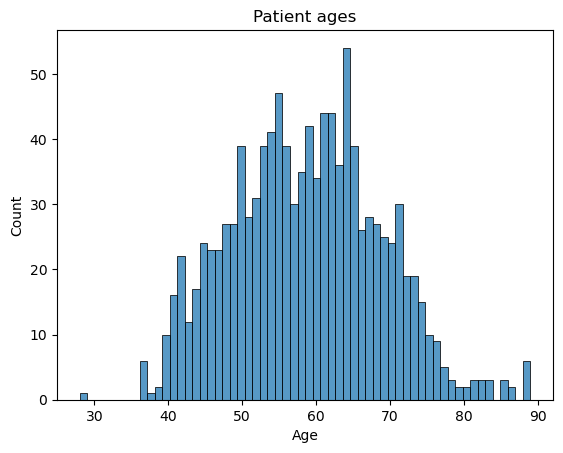

In [16]:
patient_age = nocancer[nocancer['age'].isnull()==False].groupby("patient_id").age.unique().apply(lambda a: get_age(a))
sns.histplot(patient_age.values, bins=60)
plt.xlabel("Age")
plt.title("Patient ages")

In [17]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression


In [21]:
image_path  = Path('png_train_images/')

path = []

for i in tqdm(range(len(df))):
    row = df.iloc[i, :]
    filename = str(row.patient_id) + "/" +str(row.image_id) + ".png"
    path.append(str(image_path /  filename))  
path[:5] 

X = []
y = []

  0%|          | 0/54706 [00:00<?, ?it/s]

In [19]:
image_path  = 'png_train_images/'
folders = os.listdir(image_path)

In [32]:
for folder in folders:
    for img in os.listdir(os.path.join(image_path, folder)):
        print(os.path.join(image_path, folder, img))
        print(folder)

png_train_images/1069/1313414003.png
1069
png_train_images/1069/725941064.png
1069
png_train_images/1069/1311352975.png
1069
png_train_images/1069/426661175.png
1069
png_train_images/48123/1885792542.png
48123
png_train_images/48123/1806156973.png
48123
png_train_images/48123/261437531.png
48123
png_train_images/48123/949400271.png
48123
png_train_images/19781/686864942.png
19781
png_train_images/19781/1627243602.png
19781
png_train_images/19781/593203196.png
19781
png_train_images/19781/233734201.png
19781
png_train_images/65009/1839724317.png
65009
png_train_images/65009/847789550.png
65009
png_train_images/65009/1255308688.png
65009
png_train_images/65009/2107778379.png
65009
png_train_images/65009/473819353.png
65009
png_train_images/65009/46008825.png
65009
png_train_images/12967/755166795.png
12967
png_train_images/12967/1782378065.png
12967
png_train_images/12967/235238581.png
12967
png_train_images/12967/1310745132.png
12967
png_train_images/9036/791453915.png
9036
png_train_im

NotADirectoryError: [Errno 20] Not a directory: 'png_train_images/.DS_Store'

In [44]:
#train_files = []
#target_files = []
#for folder in folders:
#    for img in os.listdir(os.path.join(image_path, folder)):
#        train_files.append(os.path.join(image_path, folder, img))
#        target_files.append(folder)

In [37]:
import os

train_files = []
target_files = []

for folder in folders:
    folder_path = os.path.join(image_path, folder)

    # Check if the path is a directory
    if os.path.isdir(folder_path):
        for img in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img)

            # Check if the path is a file (to avoid .DS_Store or other non-directory files)
            if os.path.isfile(img_path):
                continue

            train_files.append(img_path)
            target_files.append(folder)


In [45]:
df_img = pd.DataFrame({'img' : train_files, 'target' : target_files})
df_img.head()

,img,target
0,png_train_images/1069/1313414003.png,1069
1,png_train_images/1069/725941064.png,1069
2,png_train_images/1069/1311352975.png,1069
3,png_train_images/1069/426661175.png,1069
4,png_train_images/48123/1885792542.png,48123


In [50]:
!pip install tqdm

import tqdm

In [52]:
img = []
for ind in tqdm.tqdm(range(len(df_img['img']))):
    origImage = cv2.imread(df_img['img'][ind])
    origImage = cv2.resize(origImage, (256, 256))
    img.append(origImage)
df_img['img'] = img

100%|██████████████████████████████████████| 7961/7961 [00:19<00:00, 398.74it/s]


In [77]:
len(df_img['target'].unique())

1724

In [57]:
y = []
for i in range(len(df_img['target'])):
    for j in range(len(folders)):
        if df_img['target'][i] == folders[j]:
            y.append(j)

In [150]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(img, y, test_size=0.2, random_state=10)

In [151]:
len(y_train)

6368

In [152]:
len(y_test)

1593

In [192]:
class MyConvNet(nn.Module):
    def __init__(self):
        super(MyConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5)

        self.fc_input_size = self.calculate_fc_input_size()
        
        self.fc1 = nn.Linear(self.fc_input_size, 476288)
        self.fc2 = nn.Linear(476288, 84)
        self.fc3 = nn.Linear(84, 1724)


    def calculate_fc_input_size(self):
        x = torch.randn(1, 3, 256, 256)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        size = x.view(x.size(0), -1).size(1)
        print("Calculated FC Input Size:", size)  
        return size

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    


In [194]:
import torch
import torchvision
from torchvision import transforms
from torchsummary import summary
from torch.utils.data import DataLoader,Dataset
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
class MyDataset(Dataset):
    def __init__(self, data, targets,transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        if self.transform:
            x = Image.fromarray(self.data[index].astype(np.uint8))
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)
%matplotlib inline
transform = transforms.Compose([transforms.ToTensor()])
dataset = MyDataset(X_train,y_train, transform=transform)
trainloader = DataLoader(dataset, batch_size=4)

testset = MyDataset(X_test,y_test, transform=transform)
testloader = DataLoader(testset, batch_size=4)

In [195]:
trainloader

In [ ]:
if torch.cuda.is_available():
      net = MyConvNet().cuda()
else:
      net = MyConvNet()

batch = []

batch = next(iter(trainloader))
print(batch[0].shape)

Calculated FC Input Size: 476288


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [190]:
import torch.nn as nn
import torch.nn.functional as F 

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
train_losses = []
test_losses = []
all_predictions = []
running_loss = 0
# итерируемся
for epoch in (range(10)):
    train_loss = []
    test_loss = []
    for i, batch in enumerate(trainloader):
        X_batch, y_batch = batch
        X_batch = X_batch.to(device=device, dtype=torch.float32)
        y_batch = y_batch.to(device = device, dtype = torch.long)
        optimizer.zero_grad()
        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        net.train(False)

    with torch.no_grad():
        for i, batch in enumerate(testloader):
            X_test_batch, y_test_batch = batch
            X_test_batch = X_test_batch.to(device=device, dtype=torch.float32)
            y_test_batch = y_test_batch.to(device=device, dtype=torch.long)
            y_test_pred = net(X_test_batch)
            test_l = loss_fn(y_test_pred, y_test_batch)
            test_loss.append(test_l.item())
 #           all_predictions.extend(y_test_pred.argmax(dim=1).cpu().numpy())

    train_losses.append(np.mean(train_loss))
    test_losses.append(np.mean(test_loss))
    print('epoch ',epoch, ' train_loss ',np.mean(np.mean(train_loss)), ' test_loss ',np.mean(test_loss))

In [ ]:
with torch.no_grad():
    for i, batch in enumerate(testloader):
        X_test_batch, y_test_batch = batch
        X_test_batch = X_test_batch.to(device=device, dtype=torch.float32)
        y_test_batch = y_test_batch.to(device=device, dtype=torch.long)
        y_test_pred = net(X_test_batch)
        all_predictions.extend(y_test_pred.argmax(dim=1).cpu().numpy())


from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, all_predictions)
print("Confusion Matrix:")
print(cm)

from sklearn.metrics import classification_report
cr = classification_report(y_test, all_predictions)
print("Classification Report:")
print(cr)